In [45]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import textwrap

In [3]:
model_id = "meta-llama/Llama-3.1-8b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:46<00:00, 11.56s/it]


loss is 1.787671685218811
loss is 3.6628642082214355
loss is 1.3933583498001099
loss is 4.036296844482422
loss is 4.323160648345947
loss is nan
loss is 4.52361536026001
loss is 2.557591199874878
loss is 2.1320979595184326
loss is nan
loss is 3.4643959999084473
loss is 6.296201229095459
loss is 5.286160945892334
loss is 4.3792901039123535
loss is 6.0095086097717285
loss is 3.6039135456085205
loss is 4.3909687995910645
loss is 2.386716604232788
loss is 2.6085588932037354
loss is 5.707316875457764
loss is 9.674243927001953


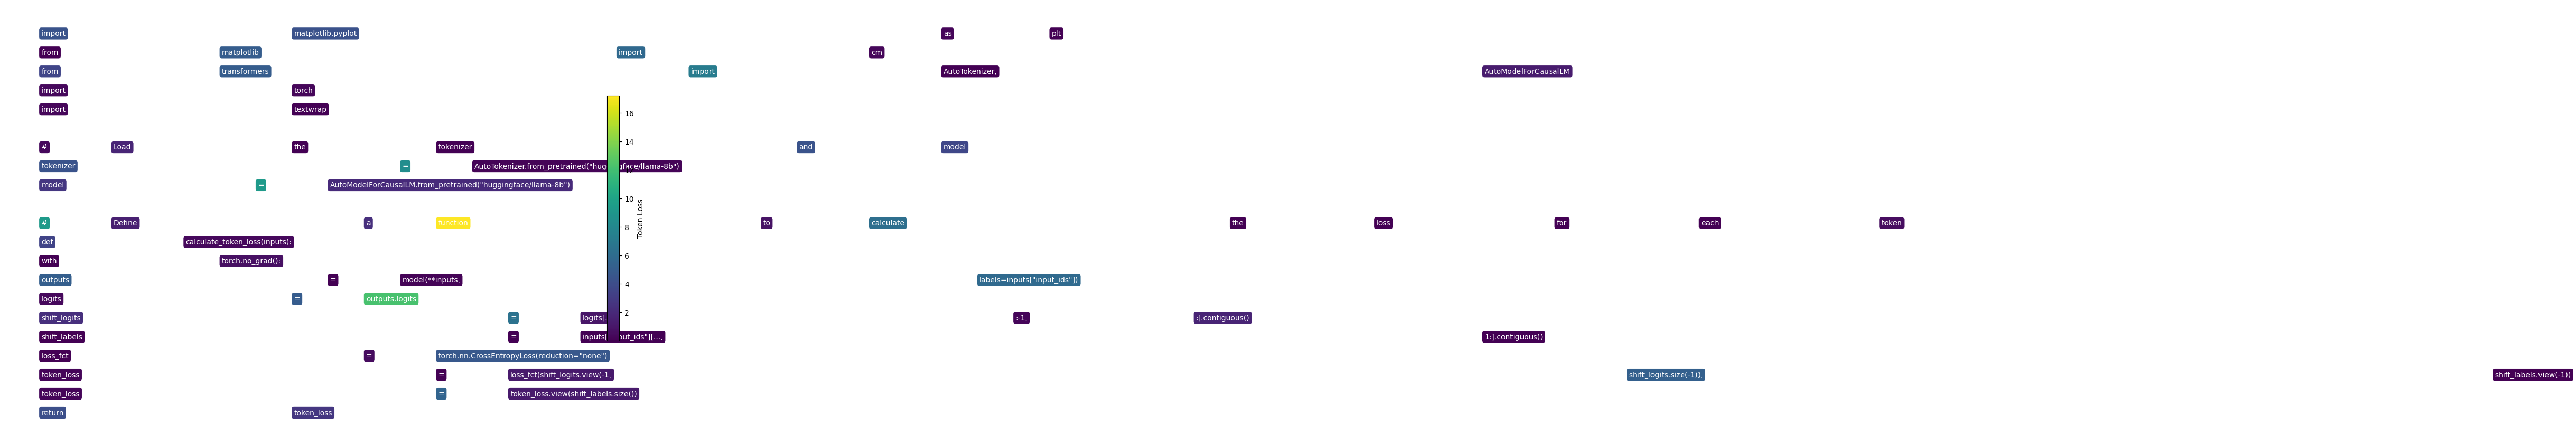

In [55]:
# Step 3: Define a function to calculate the loss for each token
def calculate_token_loss(inputs):
    
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    print(f"loss is {loss}")
    logits = outputs.logits
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = inputs["input_ids"][..., 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    token_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    token_loss = token_loss.view(shift_labels.size())
    return token_loss

# Define a function to visualize the tokens with colors based on their loss
def visualize_token_loss(prompt):
    lines = prompt.split('\n')
    token_losses = []
    tokens = []
    
    for line in lines:
        inputs = tokenizer(line, return_tensors="pt").to(model.device)
        token_loss = calculate_token_loss(inputs)
        token_losses.extend(token_loss[0].cpu().numpy())
        tokens.extend(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
    
    # Normalize the loss values for coloring
    norm = plt.Normalize(min(token_losses), max(token_losses))
    colors = cm.viridis(norm(token_losses))
    
    # Ensure the lengths match
    colors = colors[:len(tokens)]
    
    # Adjust figure size based on the number of lines
    num_lines = len(lines)
    fig_width = 15
    fig_height = num_lines * 0.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='white')
    
    # Plot the tokens with background colors
    y = num_lines - 1
    token_idx = 0
    for line in lines:
        words = line.split()
        x = 0
        for word in words:
            if token_idx < len(colors):
                ax.text(x, y, word, fontsize=10, ha='left', va='center',
                        bbox=dict(facecolor=colors[token_idx], edgecolor='none', boxstyle='round,pad=0.3'), color='white')
                x += len(word) + 1  # Move x position to the right
                token_idx += 1
        y -= 1
    
    ax.set_xlim(-1, fig_width)
    ax.set_ylim(-1, num_lines + 0.5)  # Add padding to the bottom
    ax.axis('off')

    # Add a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Token Loss')
    
    plt.show()

# Step 5: Display the visualization in the Jupyter Notebook
prompt = """import matplotlib.pyplot as plt
from matplotlib import cm
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import textwrap

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("huggingface/llama-8b")
model = AutoModelForCausalLM.from_pretrained("huggingface/llama-8b")

# Define a function to calculate the loss for each token
def calculate_token_loss(inputs):
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    logits = outputs.logits
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = inputs["input_ids"][..., 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    token_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    token_loss = token_loss.view(shift_labels.size())
    return token_loss"""
visualize_token_loss(prompt)